## Image Captioning


In [ ]:
 ! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download adityajn105/flickr8k

 98% 1.01G/1.04G [00:05<00:00, 267MB/s]
100% 1.04G/1.04G [00:05<00:00, 206MB/s]


In [ ]:
! mkdir flickr8k

In [ ]:
! unzip flickr8k.zip -d flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/Images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/Images/2849194983_2968c72832.jpg  
  inflating: flickr8k/Images/28507194

### Import

In [ ]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from scipy.sparse import csr_matrix
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical   
from keras import datasets, layers, models
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
pd.set_option('max_colwidth', 150)

### Load data

In [ ]:
captions = pd.read_csv("/content/flickr8k/captions.txt")
captions

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


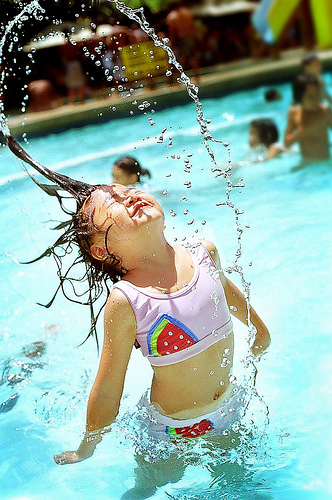

a young girl jumping out of the water at a pool
A young girl whips her hair over her head in a public pool
Girl in swimming pool flinging her hair back over her head .
Girl slinging water out of hair while in a pool .
Little girl in watermelon swimsuit , emerges from pool and flips wet hair .


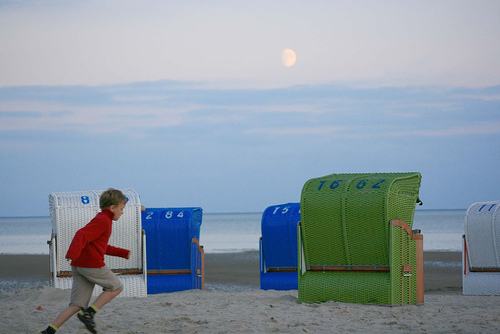

A boy dressed in khaki shorts and a red shirt runs on a beach with green , white and blue structures and a half moon behind him .
A boy in a red sweater running on the beach
A boy wearing a red shirt runs along a beach .
A boy wearing a red sweater runs along a colorful beach .
Young boy in red runs on beach and passes white , blue and green beach huts .


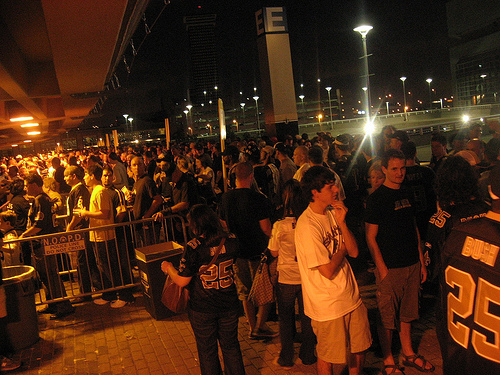

A crowd of people .
A crowd of people are lining up outside a stadium .
A large crowd of people are waiting in a line in the dark .
A large crowd of people wait in line to get into a football game .
Large group of people lining up for an event , outdoors at night .


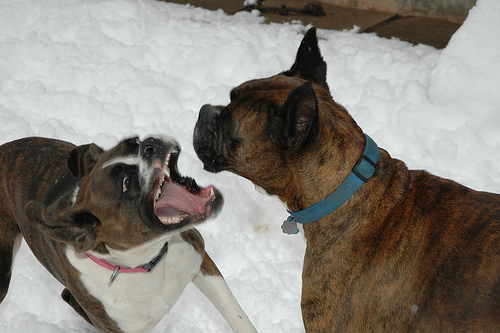

A brown and white dog with a pink collar is barking at a brown dog with a blue collar in the snow .
A dark brown dog is biting at a lighter brown colored dog .
The dog with the red collar is bearing its teeth at the dog with the blue collar .
Two dogs are on a white carpet with one of the dogs showing its fangs .
Two dogs , one with mouth open .


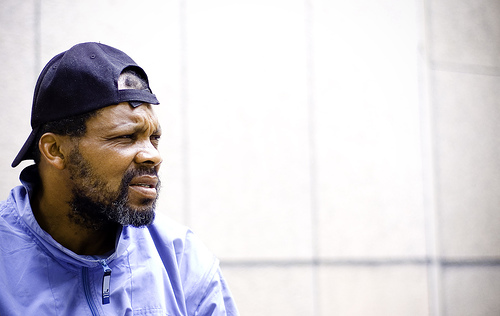

A black man with facial hair wears a navy hat and blue jacket in front of a white background .
A man in blue cap and jacket looks frustrated .
A man wearing a backwards baseball cap .
A man wearing a blue baseball cap is gazing into the distance .
A man with a beard and a navy blue backwards baseball cap stares intently at something in the distance .


In [ ]:
def display_random_data(count=5, seed=1):#func to generate a random picture with 5 captions
    np.random.seed(seed)
    # random choose images == count
    images = np.random.choice(captions['image'].unique(), count)#Generates a random sample from a given 1-D array
    # display and their captions
    for image in images:
        # display image
        display(Image.open(f'/content/flickr8k/Images/{image}'))
        # display caption
        #loc Access a group of rows and columns by label(s) or a boolean array.
        img_captions = captions.loc[captions['image']==image, 'caption'].tolist()
        for cap in img_captions:
            print(cap)
display_random_data(5)

## Prepare data for training
- Prepare the caption data
    - Prepare for Recurrent layer input.
    - Usual preprocessing (lower, punctuations, ..)
    - Limit the size and add <start>, <end> prefix and suffix resp.

In [ ]:
# constants
config = {
    'max_vocab': 10000,
    'test_ratio': 0.1,
    'batch_size': 32,
    'steps_per_epoch': 1000,
    'epochs': 80
}

In [ ]:
#This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) 
#or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

# create the captions with start and end tag
# Adding prefix <start> and suffix <end> to each of our captions.
# This should make it easier for our recurrent module to learn the boundary of the caption.
y = captions['caption'].apply(lambda x: '<start> ' + x.lower() + ' <end>')

# tokenize the captions
tokenizer = Tokenizer(num_words=config['max_vocab'],#the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
                      filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',#a string where each element is a character that will be filtered from the texts
                      oov_token=0)#if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls

tokenizer.fit_on_texts(y)#This method creates the vocabulary index based on word frequency.,create 
sequences = tokenizer.texts_to_sequences(y)# Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. 

# get constant
config['max_len'] = max([len(x) for x in sequences]) 
# pad the sequneces
#This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape
sequences = pad_sequences(sequences, maxlen=config['max_len'], dtype='int32', padding='post', truncating='post', value=0)
#sequences : data after prerocessing
#mexlen depended :  sequences will be padded to the length of the longest individual sequence.
#dtype :    default
# padding : pad either before or after each sequence.
#truncating :remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.
#value :default 0

# add sequences to the caption df
captions['sequences'] = sequences.tolist()#used to convert the data elements of an array into a list.

In [ ]:
print(captions['sequences'] )

0        [3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 5160, 671, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1                  [3, 2, 20, 317, 65, 2, 197, 118, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2                [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3               [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4             [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                                                                          ...                                                                   
40450              [3, 2, 12, 5, 2, 91, 37, 252, 2, 86, 123, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print(captions.index)
print(captions.shape[0])
print(config['test_ratio'])

RangeIndex(start=0, stop=40455, step=1)
40455
0.1


In [ ]:
# get train/test split, with holdout = 10%
random.seed(10)
test_indices = random.sample(list(captions.index), int(config['test_ratio']*captions.shape[0]))
train_indices = [x for x in list(captions.index) if x not in test_indices]

- Prepare the image data: 
    - Resize all images to a specific size.
    - Load the data and save to a variable.
    - [Later] Use augmented images to increase data hence generality.

In [ ]:
# create datagenerator  which will load the data and pass it to the model for training.
def data_generator(pick_from_caption_indices, batch_size=32, reproduce=False):
    while True:
        img_2_arrs, one_hot_captions = [], []
        # get the indices
        #reproduce to return the same order of (image, caption) pairs.
        if reproduce:
            random.seed(1)
        indices = random.sample(pick_from_caption_indices, batch_size)
        # get the relevant rows
        df = captions.loc[indices, ['image', 'sequences']]
        
        # for each batch size ,We repeat the following process till we have (image, caption) pairs equal to the batch_size (=32).
        for row in df.to_dict(orient='records'):
            # load the image
            #lso resize it to (229, 229, 3) shape.
            #This will make sure every image is of the same size. Also, we are keeping the color information by keeping all 3 channels.
            image = load_img(f"/content/flickr8k/Images/{row['image']}", color_mode="rgb"
                             , target_size=(229, 229, 3))
            img_2_arr = img_to_array(image) / 255
            #Convert the sequence data (from preprocessing) to one-hot encoding:which is binary class matrix array, so that classification can be done
            #This takes one sequence of numbers of length 39 and returns a matrix of size (39, 10000) 
            #This is because our max vocabulary size is 10k, so for each step of the sequence 
            # we create a 10k sized vector with 0 everywhere except the number at that step.
            one_hot_caption = to_categorical(row['sequences'], num_classes=config['max_vocab'])    
            # append
            img_2_arrs.append(img_2_arr)
            
            one_hot_captions.append(one_hot_caption)
            
        # return
        yield np.array(img_2_arrs), np.array(one_hot_captions)

# create the data generators
train_data_gen = data_generator(train_indices, config['batch_size'])
print(train_data_gen)
test_data_gen = data_generator(test_indices, 5, True)
print(test_data_gen)


<generator object data_generator at 0x7f12ad04b2d0>
<generator object data_generator at 0x7f12acab1450>


## Model creation Version 1

- Encoder: Custom CNN 
- Decoder: LSTM


In [ ]:
# start
model = models.Sequential()
# CNN part ,input_shape=(229, 229, 3) because we resizit to that shape 
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(229, 229, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# Flatten ,We flatten the last layer to create a single vector as the image representation.
model.add(layers.Flatten())
# This is the final CNN layer, where we have reduced the image representation to a 256D sized vector.
model.add(layers.Dense(256, activation='relu'))

#NLP part
#As the LSTM layer require input to all of its steps,
# we will repeat the image vector where is it inputand pass it to all steps of the LSTM as input. Here the step is config['max_len'] (=39).
model.add(layers.RepeatVector(config['max_len']))


#LSTM will take the image vector as input 
# and for the course of its length give out vector representations which we will translate to a word by using the softmax function.
#return_sequence is True as we want to return output for all of the steps.
model.add(layers.LSTM(256, return_sequences=True))

#For each of the steps, we will pass the vector representation to a dense layer which acts as the classifier part
# and picks one of the config['max_vocab'] (=10k) words. Doing this over all of the steps, and we will get our caption!
model.add(layers.TimeDistributed(layers.Dense(config['max_vocab'], activation='softmax')))
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 227, 227, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

## Model creation version 2
- Encoder: Pre-trained Keras CNN model
- Decoder: biLSTM

In [ ]:
import keras
import tensorflow as tf
# # start
model = models.Sequential()
# # Pretarined CNN models (Keras Applications)
app = tf.keras.applications.Xception(
      include_top=False,
      weights="imagenet",
      ##input_shape=(229, 229, 3) because we resizit to that shape 
      input_shape=(229, 229, 3),
      pooling="avg",)

app.trainable = False
model.add(app)
#added a 256D dense layer to get the final translated image.
model.add(layers.Dense(256, activation='relu'))



#NLP part
#As the LSTM layer require input to all of its steps,
# we will repeat the image vector where is it inputand pass it to all steps of the LSTM as input. Here the step is config['max_len'] (=39).
model.add(layers.RepeatVector(config['max_len']))


#LSTM will take the image vector as input 
# and for the course of its length give out vector representations which we will translate to a word by using the softmax function.
#return_sequence is True as we want to return output for all of the steps.
model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True)))

#For each of the steps, we will pass the vector representation to a dense layer which acts as the classifier part
# and picks one of the config['max_vocab'] (=10k) words. Doing this over all of the steps, and we will get our caption!
model.add(layers.TimeDistributed(layers.Dense(config['max_vocab'], activation='softmax')))

# # summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 repeat_vector (RepeatVector  (None, 39, 256)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 39, 512)          1050624   
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 39, 10000)        5130000   
 ibuted)                                                         
                                                        

In [ ]:
# define the callbacks
#checkpoint callback which saves the best model over the course of the last 10 epochs.
checkpoint = ModelCheckpoint("checkpoint_model_{epoch:02d}.hdf5", monitor='loss', verbose=1,
    save_best_only=False, mode='auto', period=10)
#Early stopping callback which stops the training if we haven't seen any significant progress over 10 epochs.
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# compile the model
model.compile(optimizer='adam', loss="categorical_crossentropy")

# fit the model
history = model.fit(train_data_gen, 
                    epochs=config['epochs'],
                    steps_per_epoch=config['steps_per_epoch'],
                    verbose=1, 
                    callbacks=[checkpoint, earlystopping]
                   )

Epoch 1/80
1000/1000 [==============================] - 262s 248ms/step - loss: 1.8316
Epoch 2/80
1000/1000 [==============================] - 246s 246ms/step - loss: 1.5600
Epoch 3/80
1000/1000 [==============================] - 245s 245ms/step - loss: 1.4934
Epoch 4/80
1000/1000 [==============================] - 246s 246ms/step - loss: 1.4262
Epoch 5/80
1000/1000 [==============================] - 249s 249ms/step - loss: 1.3874
Epoch 6/80
1000/1000 [==============================] - 246s 246ms/step - loss: 1.3456
Epoch 7/80
1000/1000 [==============================] - 247s 247ms/step - loss: 1.3104
Epoch 8/80
1000/1000 [==============================] - 246s 246ms/step - loss: 1.2767
Epoch 9/80
1000/1000 [==============================] - 248s 248ms/step - loss: 1.2518
Epoch 10/80
1000/1000 [==============================] - ETA: 0s - loss: 1.2240
Epoch 10: saving model to checkpoint_model_10.hdf5
1000/1000 [==============================] - 245s 245ms/step - loss: 1.2240
Epoch 11/8

In [ ]:
# local save
model.save("image_captioning_model") 

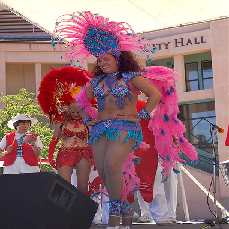

Caption: 
 <start> several women in outdoors colored colored <end> # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


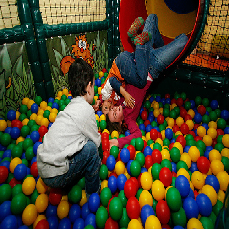

Caption: 
 <start> two children slide a a slide <end> a ball pit # # # # # # # # # # # # # # # # # # # # # # # # # # # #


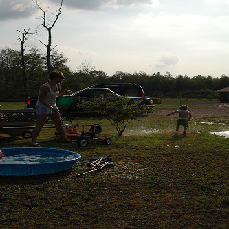

Caption: 
 <start> a child is running a from a a outside a a # # # # # # # # # # # # # # # # # # # # # # # # # # #


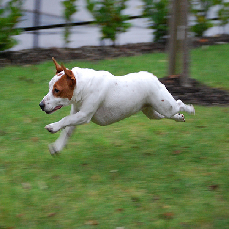

Caption: 
 <start> a white and brown dog runs through a field # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


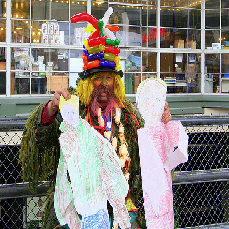

Caption: 
 <start> a clown shares cut holding pictures two child cut # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
